In [1]:
from sortedcontainers import SortedDict
from urllib.request import urlopen
from bs4 import BeautifulSoup
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib as plt

import json

%matplotlib inline

In [2]:
data = []

In [3]:
d = SortedDict()

with open('data/root.zone') as f:
    for i in range(21):
        next(f)
        
    for line in f:
        values = line.split('\t')
        if 'NS' in values:
            tld = values[0][:-1]
            ns = values[-1][:-2]
            if tld in d:
                d[tld].append(ns)
            else:
                d[tld] = [ns]

In [4]:
f = open('test.csv', 'w')
f.write('tld,ns\n')
for i in d:
    for j in d[i]:
        f.write(i + ',' + j + '\n')
        
f.close()

In [ ]:
df = pd.read_csv("test.csv")
df2 = df.groupby('tld')['ns'].nunique()
df2.head()

In [5]:
url = "https://www.iana.org/domains/root/db/"
html = urlopen(url)
soup = BeautifulSoup(html, 'html5lib')

for item in soup.find_all(attrs={'class': 'iana-table'}):
    for table in soup.find_all(attrs={'class': 'iana-table'}):
        values = [td.get_text(strip=True) for td in table.find_all('td')]

        for i in range(0, len(values), 3):
            data.append({'tld': values[i].strip('.'), 'type': values[i + 1], 'organisation': values[i + 2]})

In [9]:
df = pd.DataFrame(data)

with open('data/tld_type', 'w') as f:
    f.write(json.dumps(data))

In [ ]:
for tld in data:
    data[tld]['nameservers'] = SortedDict()
    html = urlopen(url + tld)
    soup = BeautifulSoup(html, 'html5lib')

    for br in soup.find_all('br'):
        br.replace_with('\t')

    for item in soup.find_all(attrs={'class': 'iana-table'}):
        for table in soup.find_all(attrs={'class': 'iana-table'}):
            values = [td.get_text(strip=False) for td in table.find_all('td')]
            
            print(values[1].split('\t')[:-1])

            for i in range(0, len(values), 2):
                ips = values[i + 1].split('\t')
                
                data[tld]['nameservers'][values[i]] = SortedDict()
                
                if '.' in ips[0]:
                    data[tld]['nameservers'][values[i]]['ipv4'] = ips[0]
                elif '.' in ips[1]:
                    data[tld]['nameservers'][values[i]]['ipv4'] = ips[1]
                    
                if 'nameservers' in data[tld]:
                    data[tld]['nameservers'].append((values[i], values[i + 1].split('\t')))
                else:
                    data[tld]['nameservers'] = [(values[i], values[i + 1].split('\t'))]

In [5]:
df = pd.DataFrame(data)

In [72]:
df.groupby('organisation')['tld'].agg(['count']).sort_values('count', ascending=False).head(10)

,count
organisation,
"Amazon Registry Services, Inc.",51
Charleston Road Registry Inc.,43
"Uniregistry, Corp.",22
United TLD Holdco Ltd.,22
Top Level Domain Holdings Limited,18
Afilias plc,14
Not assigned,14
Internet Assigned Numbers Authority,12
"Lifestyle Domain Holdings, Inc.",11


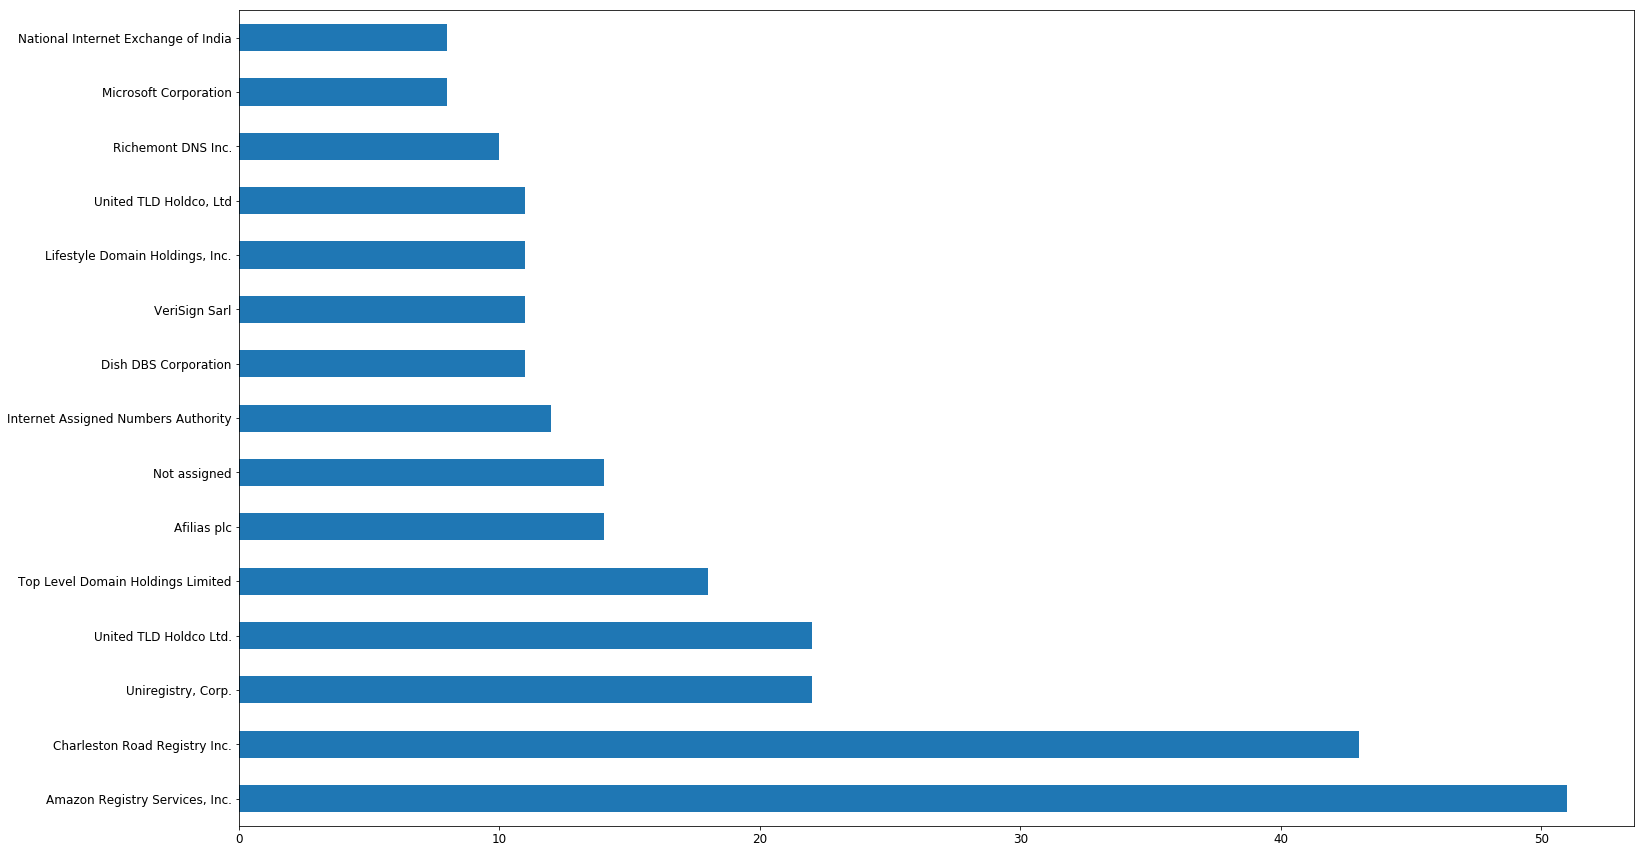

In [71]:
plot = counts.head(15).plot.barh(figsize=(25,15))
fig = plot.get_figure()
fig.savefig("imgs/tld_orgs.png")

In [7]:
df.to_csv('temp.csv')